In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pylab import rcParams

In [232]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [233]:
etf=pd.read_csv('/content/drive/Shareddrives/Capstone B1/Spinnaker Data/US Sector Inst ETF.csv')
institutional=pd.read_csv('/content/drive/Shareddrives/Capstone B1/Spinnaker Data/US Sector Institutional MF.csv') 
retail=pd.read_csv('/content/drive/Shareddrives/Capstone B1/Spinnaker Data/US Sector Retail MF.csv')

In [234]:
missingAsset = 'Infrastructure-North America-USA-North America-Equity'

etf.drop(etf[etf['AssetClass'] == missingAsset].index, inplace=True)
institutional.drop(institutional[institutional['AssetClass'] == missingAsset].index, inplace=True)
retail.drop(retail[retail['AssetClass'] == missingAsset].index, inplace=True)

In [235]:
# ARIMA Model

# define a function for preprocessing dataset
def preprocessing(df): 
  # trim AssetClass names
  df['AssetClass'] = df['AssetClass'].str.replace('-North America-USA-North America-Equity', '')

  # convert ReportDate to datetime 
  df['ReportDate'] = pd.to_datetime(df["ReportDate"])
  
  # extract year
  df['year'] = df['ReportDate'].dt.year

  # set ReportDate as index
  df.sort_values("ReportDate", inplace=True)
  df.set_index('ReportDate', inplace=True)
  return df

In [236]:
etf = preprocessing(etf)
institutional = preprocessing(institutional)
retail = preprocessing(retail)

In [237]:
etf.head(3)

,AssetClass,Flow,FlowPct,AssetsEnd,PortfolioChangePct,year
ReportDate,,,,,,
2006-01-04,Utilities,20.413818,3.4234,626.023766,1.5618,2006
2006-01-04,Commodities/Materials,23.148567,6.8877,365.747363,1.9393,2006
2006-01-04,Consumer Goods,11.761774,1.8150,662.337236,0.3959,2006


In [238]:
def group_by_assetclass(df):
    arraysDict = {}
    grouped = df.groupby(df['AssetClass'])
    for i in df['AssetClass']:
        arraysDict['model_{0}'.format(i)] = grouped.get_group(i)
    return arraysDict

# carry-out the train-test split of the data and keep the last 58-weeks as test data.
def split(arraysDict, observations=58):
  global train
  global test
  train_dict = {}
  test_dict = {}
  for key in arraysDict.keys():
      # columns to drop and split train test sets
      arraysDict.get(key).drop(['AssetClass','year','Flow','FlowPct','PortfolioChangePct'], axis = 1, inplace = True)
      arraysDict.get(key).dropna()

      #train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]

      train_dict[key] = np.log(arraysDict.get(key).iloc[:-observations,:])
      test_dict[key] = np.log(arraysDict.get(key).iloc[-observations:,:])
  return train_dict, test_dict

In [239]:
arraysDict_etf = group_by_assetclass(etf)
arraysDict_institutional = group_by_assetclass(institutional)
arraysDict_retail = group_by_assetclass(retail)

In [240]:
arraysDict_etf

{'model_Commodities/Materials':                        AssetClass        Flow  ...  PortfolioChangePct  year
 ReportDate                                     ...                          
 2006-01-04  Commodities/Materials   23.148567  ...              1.9393  2006
 2006-01-11  Commodities/Materials   11.561203  ...             -0.1130  2006
 2006-01-18  Commodities/Materials   -2.269946  ...             -1.8291  2006
 2006-01-25  Commodities/Materials  -34.945224  ...              2.6315  2006
 2006-02-01  Commodities/Materials    0.000000  ...              3.2378  2006
 ...                           ...         ...  ...                 ...   ...
 2017-01-04  Commodities/Materials -254.535873  ...              2.0278  2017
 2017-01-11  Commodities/Materials  168.711676  ...              0.6521  2017
 2017-01-18  Commodities/Materials  -92.853355  ...              0.0477  2017
 2017-01-25  Commodities/Materials  250.733560  ...              3.2382  2017
 2017-02-01  Commodities/Material

In [241]:
train_etf_dict, test_etf_dict = split(arraysDict_etf)
train_institutional_dict, test_institutional_dict = split(arraysDict_institutional)
train_retail_dict, test_retail_dict = split(arraysDict_retail)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [242]:
# Run through Var model on every train set, put them in a list with a name
def run_model(train_dict):
    model_name = []
    model_list = []
    for key in train_dict.keys():
        model_list.append(ARIMA(train_dict.get(key), order=(4,1,2)))
        model_name.append(key)
    # print(model_list)
    return model_name, model_list

# Fit the model and put them in a list, use lag 10
def fit_model(model_list):
    results = [i.fit(disp=-1) for i in model_list]
    return results

In [243]:
model_name_etf, model_list_etf = run_model(train_etf_dict)
model_name_institutional, model_list_institutional = run_model(train_institutional_dict)
model_name_retail, model_list_retail = run_model(train_retail_dict)

results_etf = fit_model(model_list_etf)
results_institutional = fit_model(model_list_institutional)
results_retail = fit_model(model_list_retail)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)
/usr/local/lib/

In [244]:
from re import I
import itertools 
# Calculate result forecast of each lagged values with the fitted models, with steps = 10
def result_forecast(results):
    predicted_results = []
    for i in results:
        predicted_results.append(i.forecast(58, alpha=0.05))
    return predicted_results

In [245]:
predicted_results_etf = result_forecast(results_etf)
predicted_results_institutional = result_forecast(results_institutional)
predicted_results_retail = result_forecast(results_retail)

In [246]:
predicted_results_retail

[(array([9.47580666, 9.47885349, 9.48191569, 9.48493141, 9.48792267,
         9.49089302, 9.49384199, 9.49677176, 9.49968334, 9.50257806,
         9.50545701, 9.50832127, 9.51117183, 9.51400961, 9.51683546,
         9.5196502 , 9.52245456, 9.52524925, 9.52803492, 9.53081217,
         9.53358157, 9.53634366, 9.53909891, 9.5418478 , 9.54459075,
         9.54732815, 9.55006039, 9.55278781, 9.55551074, 9.55822947,
         9.56094429, 9.56365547, 9.56636324, 9.56906784, 9.57176948,
         9.57446836, 9.57716466, 9.57985856, 9.58255023, 9.5852398 ,
         9.58792743, 9.59061324, 9.59329735, 9.59597989, 9.59866095,
         9.60134063, 9.60401903, 9.60669624, 9.60937232, 9.61204737,
         9.61472145, 9.61739462, 9.62006695, 9.62273849, 9.62540929,
         9.62807941, 9.63074889, 9.63341778]),
  array([0.0536419 , 0.07549696, 0.08989079, 0.10285615, 0.11390789,
         0.12392639, 0.13302027, 0.1414316 , 0.14926203, 0.15661464,
         0.16355656, 0.17014508, 0.17642415, 0.18243038,

In [213]:
# Extract predicted results
def extract_predicted(results):
    predicted_results = []
    for i in results:
        predicted_results.append(i[0])
    return predicted_results

In [247]:
predicted_results_etf1 = extract_predicted(predicted_results_etf)
predicted_results_institutional1 = extract_predicted(predicted_results_institutional)
predicted_results_retail1 = extract_predicted(predicted_results_retail)

In [248]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Evaluate the forecasts by calculating the RMSE of predicted assetends and actual assetends in the test dataset
def get_actual_assetend(test_dict):
    actual_assetends = []
    for key in test_dict:
        actual_assetends.append(test_dict.get(key)['AssetsEnd'].values)
    return actual_assetends

def get_evaluation(predicted_assetends, actual_assetends):
    rmse = []
    for i, j in zip(predicted_assetends, actual_assetends):
        rmse.append(math.sqrt(mean_squared_error(i, j)))
    return rmse

In [249]:
actual_assetends_etf = get_actual_assetend(test_etf_dict)
actual_assetends_institutional = get_actual_assetend(test_institutional_dict)
actual_assetends_retail = get_actual_assetend(test_retail_dict)

In [250]:
rmse_etf = get_evaluation(predicted_results_etf1, actual_assetends_etf)
rmse_institutional = get_evaluation(predicted_results_institutional1, actual_assetends_institutional)
rmse_retail = get_evaluation(predicted_results_retail1, actual_assetends_retail)

In [253]:
data = {'Etf': rmse_etf, 'Institutional': rmse_institutional, 'Retail' : rmse_retail}
rmse_table = pd.DataFrame(data = data, index = model_name_etf)
rmse_table

,Etf,Institutional,Retail
model_Utilities,0.277810,0.235201,0.066509
model_Commodities/Materials,0.212275,0.208320,0.130194
model_Consumer Goods,0.374687,0.374687,0.109249
model_Energy,0.075513,0.081053,0.262774
model_Financials,0.297665,0.290930,0.094782
model_Health Care/Biotech,0.377350,0.377452,0.101971
model_Industrials,0.174416,0.174416,0.043181
model_Large Cap Blend,0.114160,0.075439,0.071858
model_Large Cap Growth,0.183166,0.171078,2.257005
model_Telecom,0.255516,0.255516,0.053691


Text(0.5, 1.0, 'ARIMA model with assetend prediction on each assetclass')

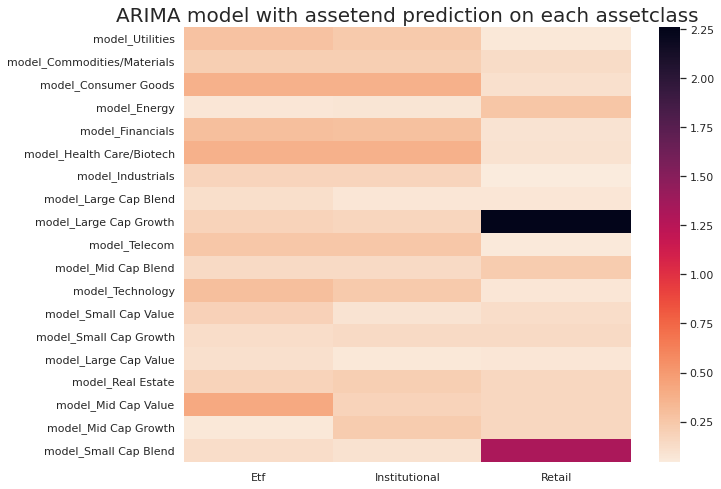

In [255]:
cmap = sns.cm.rocket_r
ax = sns.heatmap(rmse_table,cmap = cmap)
sns.set(rc = {'figure.figsize':(10,8)})
ax.set_title('ARIMA model with assetend prediction on each assetclass', fontsize =20)

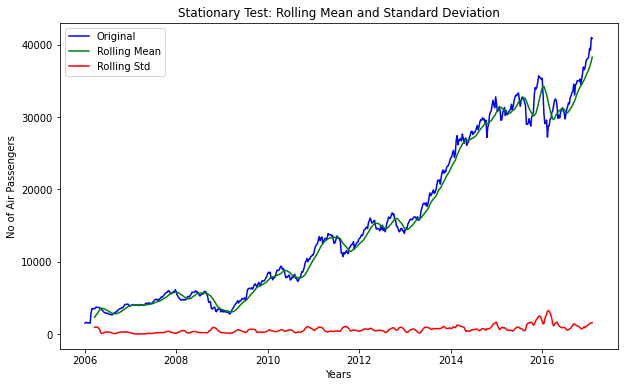

Results of Dickey-Fuller Test
Test Statistic                   1.780339
p-value                          0.998309
#Lags Used                      12.000000
Number of Observations Used    566.000000
Critical Value (1%)             -3.441956
Critical Value (5%)             -2.866660
Critical Value (10%)            -2.569497
dtype: float64


In [ ]:
# Model Sample - Technology
stationarity_test(tec_model1)

No handles with labels found to put in legend.


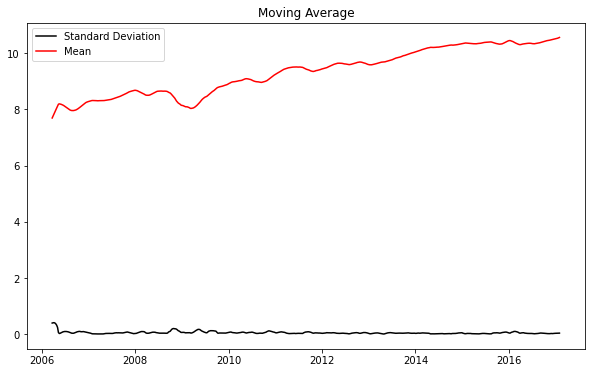

In [ ]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(tec_model1)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

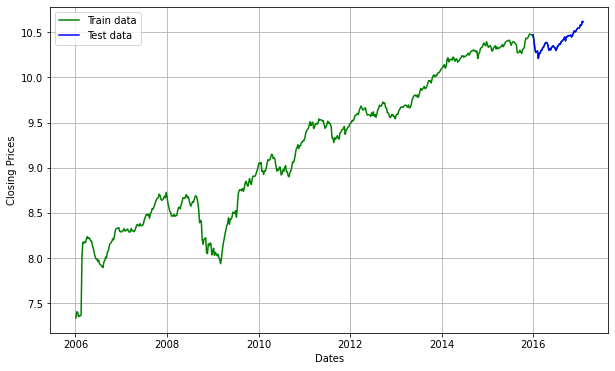

In [ ]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [ ]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.AssetsEnd   No. Observations:                  517
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 877.587
Method:                       css-mle   S.D. of innovations              0.044
Date:                Fri, 25 Feb 2022   AIC                          -1747.173
Time:                        19:28:50   BIC                          -1730.181
Sample:                    02-01-2006   HQIC                         -1740.515
                         - 12-23-2015                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0060      0.002      2.658      0.008       0.002       0.010
ar.L1.D.AssetsEnd    -0.0333      0.329     -0.101      0.919      -0.679       0.612
ma.L1.D.AssetsEnd     0.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)


In [ ]:
# Forecast
fc, se, conf = fitted.forecast(len(test_data), alpha=0.05)  # 95% conf

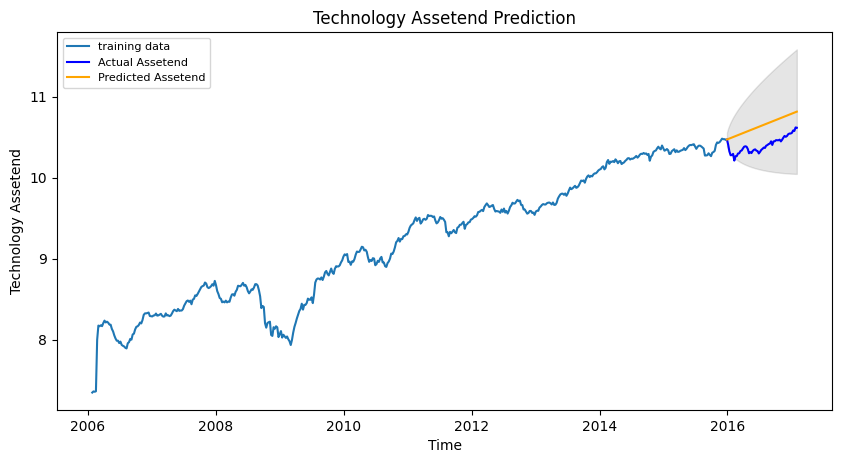

In [ ]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Assetend')
plt.plot(fc_series, color = 'orange',label='Predicted Assetend')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Technology Assetend Prediction')
plt.xlabel('Time')
plt.ylabel('Technology Assetend')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# report performance
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

fc=fc.reshape(58,1)
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.0607947870783368
MAE: 0.240682440228635
RMSE: 0.2465659892976661
MAPE: AssetsEnd    0.023147
dtype: float64


With a MAPE of around 2.3%, the model is 97.7% accurate in predicting the next 58 observations.

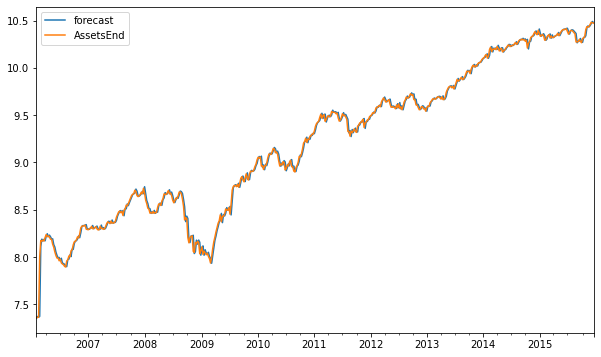

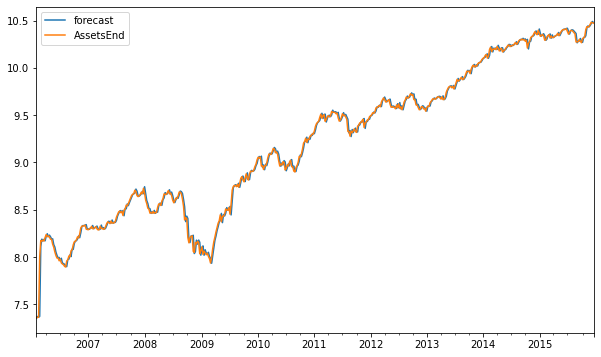

In [ ]:
fitted.plot_predict(dynamic=False) 